# Get the Data

In [448]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

In [449]:
import tensorflow as tf
#from tensorflow import keras
import keras
print(tf.__version__)
print(keras.__version__)

2.16.1
3.0.5


## Define global constants

In [450]:
MY_OPTIMIZER = "SGD"
MY_EPOCHS = 200
#MY_LEARNING_RATE = 0.1

# Get the Data

In [451]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()
maneuvers.shape

(2151, 8)

In [452]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,2151.000000,2151.000000,2.151000e+03,2151.000000,2.151000e+03,2151.000000,2.151000e+03,2.151000e+03
mean,7536.957546,-0.990424,6.175903e-07,-0.000165,2.431095e-07,-0.000005,-2.994140e-07,7.474111e-08
std,4354.500254,0.001020,3.211219e-03,0.000703,2.138460e-03,0.006599,1.451511e-03,1.078893e-07
min,0.000000,-0.991665,-4.520937e-03,-0.001121,-3.245119e-03,-0.009033,-2.050332e-03,-1.181526e-07
25%,3768.478500,-0.991457,-3.216103e-03,-0.000860,-1.976982e-03,-0.006508,-1.466374e-03,-9.900478e-09
50%,7536.958000,-0.990588,1.015676e-05,-0.000215,2.367661e-06,-0.000377,-5.864952e-06,4.617278e-08
75%,11305.435000,-0.989402,3.221367e-03,0.000531,1.975589e-03,0.006449,1.464506e-03,1.594209e-07
max,15073.920000,-0.988842,4.520490e-03,0.000898,3.245231e-03,0.009929,2.048730e-03,3.558238e-07


## Add/Drop Features

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [453]:
maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)

# Prepare the Data for Machine Learning Algorithms

In [454]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers["angle"].copy()
maneuvers_predictors = maneuvers_predictors.array.reshape(-1,1)
maneuvers_labels = maneuvers["dv_st"].copy().array.reshape(-1,1)
#maneuvers_predictors.head()
#maneuvers_labels.head()

## Create a Train/Test Set

In [455]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full, random_state=2)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
#X_train.head()

(1290, 1)
(431, 1)
(430, 1)


In [456]:
# Scale all the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train)
y_valid = scaler.transform(y_valid)
y_test = scaler.transform(y_test)
X_train_scaled[:5]

array([[0.15080491],
       [0.72963993],
       [0.12235957],
       [0.72721447],
       [0.79363744]])

# Building, Training, and Evaluating the Model

The output layer has a single neuron (since we only want to
predict a single value) and uses no activation function, and the loss function is the mean squared error. 

Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting.

In [457]:
model = keras.models.Sequential([
keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(1)
])
model.summary()

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_67 (Dense)                │ (None, 300)            │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,801 (120.32 KB)

 Trainable params: 30,801 (120.32 KB)

 Non-trainable params: 0 (0.00 B)

In [458]:
optimizer = keras.optimizers.Adam(learning_rate=1.e-4)
model.compile(loss="mean_squared_error", optimizer=optimizer)
history = model.fit(X_train_scaled, y_train, epochs=MY_EPOCHS, 
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1655 - val_loss: 0.1012
Epoch 2/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1103 - val_loss: 0.0769
Epoch 3/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0831 - val_loss: 0.0726
Epoch 4/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0735 - val_loss: 0.0697
Epoch 5/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0717 - val_loss: 0.0669
Epoch 6/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0725 - val_loss: 0.0643
Epoch 7/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0682 - val_loss: 0.0620
Epoch 8/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0618 - val_loss: 0.0600
Epoch 9/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0619 - val_loss: 0.0579
Epoch 10/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0631 - val_loss: 0.0561
Epoch 11/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0551 - val_loss: 0.0552
Epoch 12/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0337 - val_loss: 0.0311
Epoch 70/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0338 - val_loss: 0.0308
Epoch 71/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0319 - val_loss: 0.0301
Epoch 72/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0316 - val_loss: 0.0297
Epoch 73/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0320 - val_loss: 0.0292
Epoch 74/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0309 - val_loss: 0.0286
Epoch 75/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0321 - val_loss: 0.0281
Epoch 76/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0292 - val_loss: 0.0276
Epoch 77/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0307 - val_loss: 0.0270
Epoch 78/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0287 - val_loss: 0.0267
Epoch 79/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0279 - val_loss: 0.0260
Epoch 80/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0288 

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084 - val_loss: 0.0081
Epoch 138/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095 - val_loss: 0.0079
Epoch 139/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 140/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087 - val_loss: 0.0078
Epoch 141/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 142/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086 - val_loss: 0.0078
Epoch 143/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 144/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085 - val_loss: 0.0073
Epoch 145/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076 - val_loss: 0.0072
Epoch 146/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0084 - val_loss: 0.0072
Epoch 147/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 - val_loss: 0.0070
Epoch 148/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

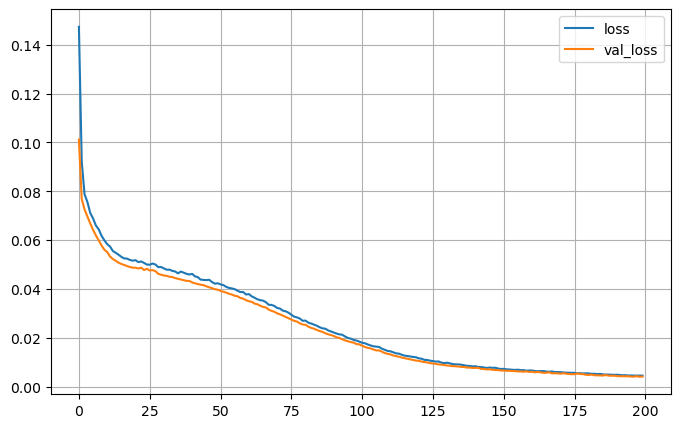

In [459]:
# Plot learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 5e-5) # set the vertical range to [0-1]
plt.show()

In [460]:
mse_test = model.evaluate(X_test_scaled, y_test)
np.sqrt(mse_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 0.0055


0.06673935831555564

In [461]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [462]:
y_test[:3]

array([[0.25684577],
       [0.72115753],
       [0.94215579]])

In [463]:
y_pred[:3]

array([[0.33966047],
       [0.8262629 ],
       [0.773115  ]], dtype=float32)

# Fine-Tuning Neural Network Hyperparameters

Wrap our Keras models in objects that mimic regular Scikit-Learn regressors.

def build_model(n_hidden, n_neurons, learning_rate, 
                input_shape):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", 
                                     **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

from scikeras.wrappers import KerasRegressor

keras_reg = KerasRegressor(build_model, n_hidden=1, n_neurons=30, learning_rate=3e-3, 
                input_shape=[8])

In [143]:
import keras
from keras import layers


def build_model(hp):
    model = keras.Sequential()
    #model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
               # Tune number of units separately for each layer.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
    model.add(layers.Dense(1))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    #learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        #optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        optimizer=MY_OPTIMIZER,
        loss="mean_squared_error",
    )
    return model


In [144]:
# Quickly test if model builds successfuly
import keras_tuner

build_model(keras_tuner.HyperParameters())

<Sequential name=sequential_3, built=False>

Use a randomized search to train hundreds of hyperparameter combinations  and see which one performs best on the validation set.

Note that RandomizedSearchCV uses K-fold cross-validation, so it
does not use X_valid and y_valid . These are just used for early stopping.

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, 
                                   n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [145]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [146]:
# print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


Then, start the search for the best hyperparameter configuration. All the arguments passed to search is passed to model.fit() in each execution. Remember to pass validation_data to evaluate the model.

In [147]:
tuner.search(X_train_scaled, y_train, epochs=MY_EPOCHS, validation_data=(X_valid_scaled, y_valid))

Trial 1 Complete [00h 00m 18s]
val_loss: 3.865438547023814e-08

Best val_loss So Far: 3.865438547023814e-08
Total elapsed time: 00h 00m 18s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
3                 |2                 |num_layers
128               |384               |units_0
160               |32                |units_1

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7047e-04 - val_loss: 4.8468e-05
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8071e-05 - val_loss: 3.9004e-05
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9745e-05 - val_loss: 3.2025e-05
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1950e-05 - val_loss: 2.6294e-05
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5892e-05 - val_loss: 2.1554e-05
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0937e-05 - val_loss: 1.7705e-05
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7122e-05 - val_loss

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5169e-08 - val_loss: 7.2436e-08
Epoch 63/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6200e-08 - val_loss: 6.9023e-08
Epoch 64/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3391e-08 - val_loss: 6.5916e-08
Epoch 65/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8377e-08 - val_loss: 6.2673e-08
Epoch 66/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2118e-08 - val_loss: 6.0079e-08
Epoch 67/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2531e-08 - val_loss: 5.6940e-08
Epoch 68/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5948e-08 - val_loss: 5.4096e-08
Epoch 69/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0508e-08 - val_loss: 5.1331e-08
Epoch 70/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6913e-08 - val_loss: 4.8870e-08
Epoch 71/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5265e-08 - val_loss: 4.5875e-08
Epoch 72/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3121e-08 - 

KeyboardInterrupt: 

## Query the results
When search is over, you can retrieve the best model(s). The model is saved at its best performing epoch evaluated on the validation_data.

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

In [ ]:
tuner.results_summary()

In [ ]:
mse_test = best_model.evaluate(X_test_scaled, y_test)
np.sqrt(mse_test)

In [ ]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = best_model.predict(X_new)

In [ ]:
y_test[:3]

In [ ]:
y_pred[:3]